In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from utils.source import DataSource
from utils.transform import DropNa, LogDiff, Rolling, Mean, Variance, StandardDeviation
from utils.compose import Compose, ForkLeft
from utils.display import Plot

We define a "asset crash" as a huge daily change in price ( > 5 standard deviations from the mean over the last trading year).

We're applying the same method illustrated in Mandelbrot's "The Misbehaviour Of Markets" (2008, Mathematical appendix).

The goal is to show how unlikely a high price change is according to a normal distribution. This in turn provides evidence of the uselessness of using a normal distribution to quantify risk.

Asset data is imported from Yahoo.

In [2]:
asset = ['BTC-USD', 'ETH-USD', '^GSPC', 'EURUSD=X', 'SI=F', 'ACAEUO.MI',
        'ACAPER.MI', 'ACABRT.MI', 'XMLC.F', 'XDW0.DE', 'BRK-A', '7309.T', 'AIGI.MI', 
         'WEAT.MI']
data = DataSource().get_data(asset)

In [4]:
data.head()

,7309.T,ACABRT.MI,ACAEUO.MI,ACAPER.MI,AIGI.MI,BRK-A,BTC-USD,ETH-USD,EURUSD=X,SI=F,WEAT.MI,XDW0.DE,XMLC.F,^GSPC
Date,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.438994,NaN,NaN,NaN,NaN,NaN
2010-01-04,3335.311768,NaN,NaN,NaN,12.69,99600.0,NaN,NaN,1.442398,17.440001,1.552,NaN,NaN,1132.989990
2010-01-05,3321.934814,NaN,NaN,NaN,12.67,99710.0,NaN,NaN,1.436596,17.781000,1.546,NaN,NaN,1136.520020
2010-01-06,3321.934814,NaN,NaN,NaN,13.17,99850.0,NaN,NaN,1.440403,18.163000,1.548,NaN,NaN,1137.140015
2010-01-07,3330.853516,NaN,NaN,NaN,13.00,100000.0,NaN,NaN,1.431803,18.333000,1.565,NaN,NaN,1141.689941


Plot asset price.

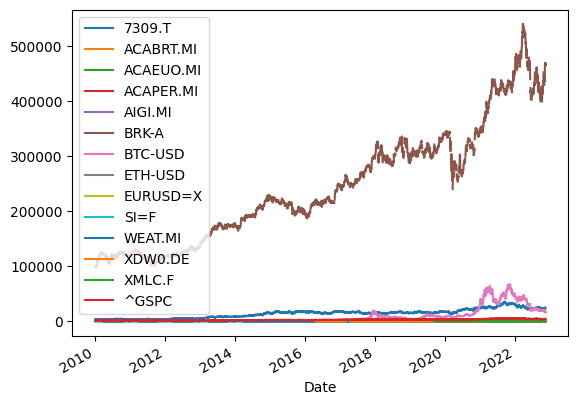

In [13]:
data = Plot().apply(data)

Compute logarithm of prices and plot daily changes. We're interested in modeling price changes, not price itself.

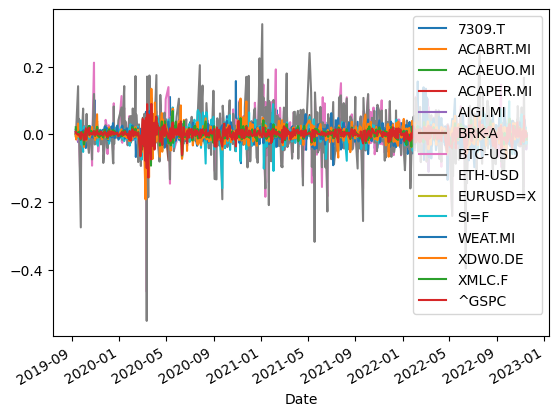

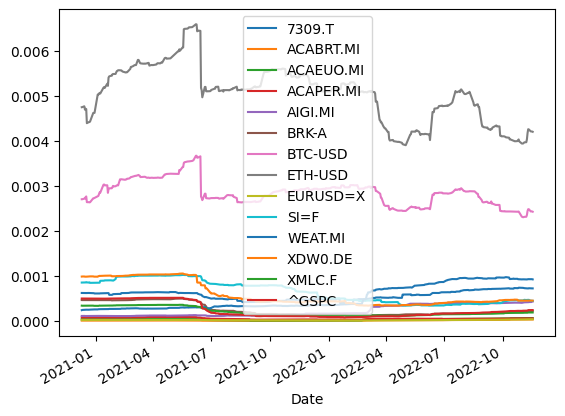

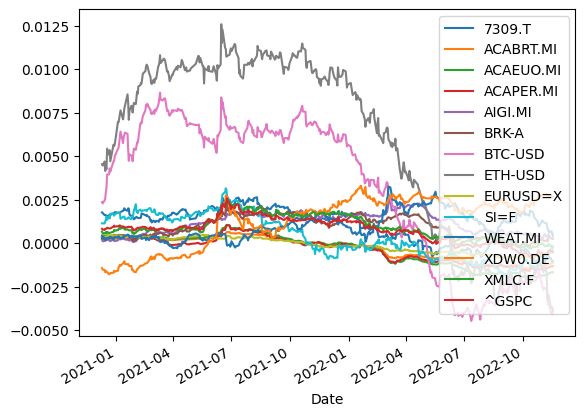

In [3]:
window_length = 250
res = Compose().then(DropNa()).then(LogDiff()).then(Plot()) \
    .then(Rolling(window_length)) \
    .then(ForkLeft(Compose().then(Mean()).then(Plot()), Compose().then(Variance()).then(Plot()))) \
    .apply(data)

Define window length to be used in all subsequent computations. We consider mean, volatility, etc., over the course of one trading year (250 days).

In [16]:
window_length = 250

Compute mean.

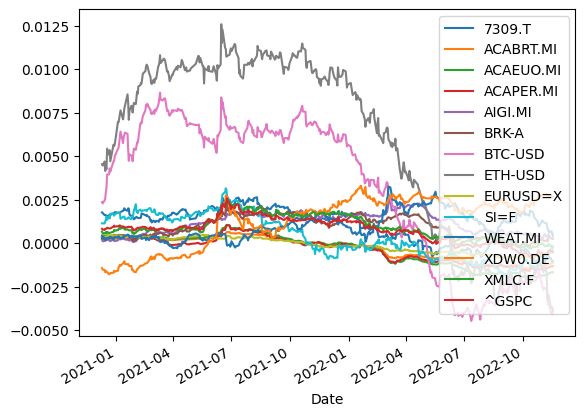

In [17]:
#rolling = Rolling(window_length).apply(data)
#mean = Compose().then(Mean()).then(Plot()).apply(rolling)


Compute variance (as if it would fit the bell curve).

<AxesSubplot: xlabel='Date'>

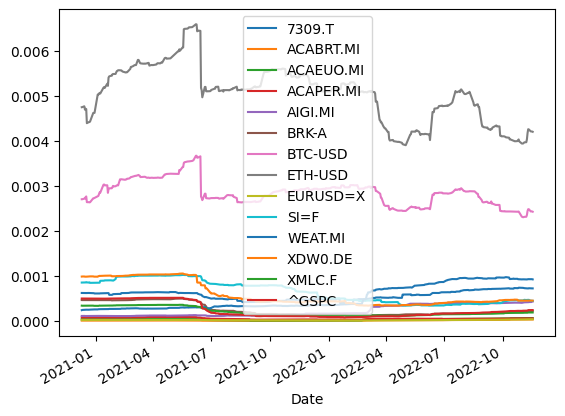

In [7]:
var = Variance().apply(rolling)
var.plot()

Compute standard deviation.

<AxesSubplot: xlabel='Date'>

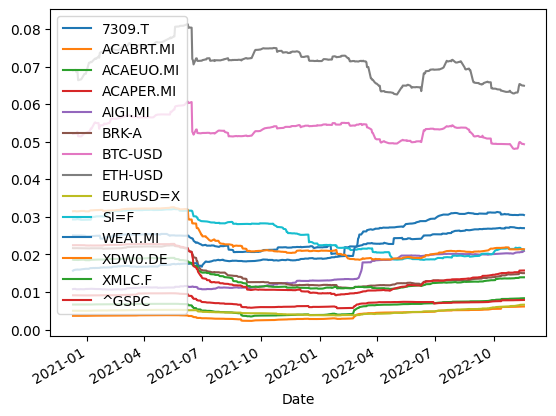

In [8]:
std = StandardDeviation().apply(rolling)
std.plot()

As we can see from this plots, variance varies wildly.

Find number of standard deviations from the mean for each day (z-score). We start after the first year, minus one because we're dealing with price changes. z-score measures how much each day is distant from the mean, expressed in standard deviations over the previous year.

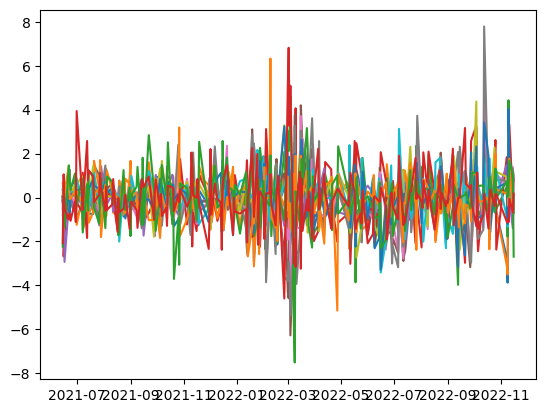

In [10]:
zscores = (log_data_diff[window_length-1:] - mean) / std
#zscores = st.zscore(log_data_diff.dropna().to_numpy())
plt.plot(zscores)

Find crashes (events with absolute high z-score, but in the negative).

In [11]:
crashes = pd.DataFrame() 
crashes[asset] = zscores[asset][zscores < -3]

Find probability of each crash. That is, getting a daily change as extreme as those in the data. We're considering those at least 4 standard deviations apart.

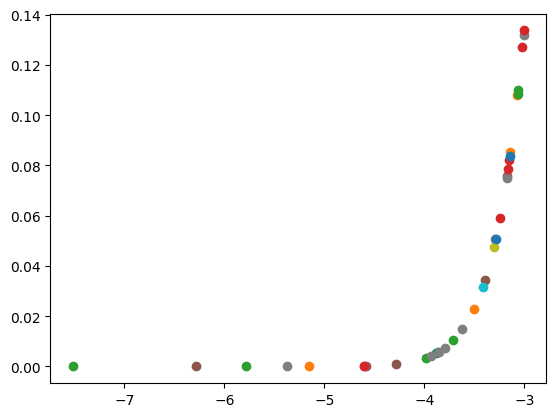

In [12]:
zscores_prob = pd.DataFrame()
zscores_prob[asset] = st.norm(0, 1).cdf(crashes)
for a in asset:
    plt.scatter(crashes[a], zscores_prob[a]*100) # percentage

Events normally considered outliers (> 3 stds), do happen consistently enough to worry about them.

Let's try to classify investments based on their z-scores.

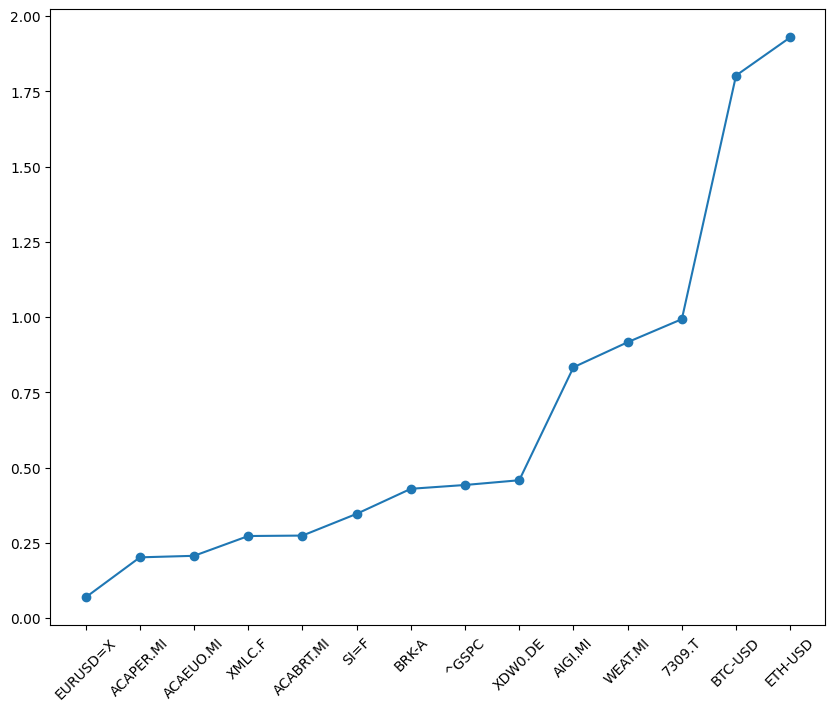

In [15]:
max_zscore = abs(zscores).max() * abs(log_data_diff).max()
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.plot(max_zscore.sort_values(), marker='o')

By taking the absolute value of z-scores we get how many standard deviations an asset differs from the mean each day, regardless of its sign. By multiplying it with the rate of daily change, again the max (it works because the max daily change is also the max z-score), we get a classification also based on actual price changes (otherwise the plain z-score would be useless inter-asset). 

The maximum value is used because we're being conservative: we need to rank risk based on the worst or best result up to now.